# SST vs Reanálisis
---

In [1]:
import numpy as np
import xarray as xr
import copernicusmarine
import re

In [2]:
# Importamos paquete local
import sys, os
sys.path.append(os.path.dirname(os.getcwd()) + '\\src')
from art1_tools import interpolation

## Rango espacial y temporal
---

In [4]:
min_lon, max_lon = (-20.97, -4.5) # IBI solo va hasta esta lon: -20.97
min_lat, max_lat = (19.55, 34.6)
start_date, end_date = ("2018", "2020-12-31") 

## Descargamos los datos
---

In [3]:
# https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download?dataset=cmems_mod_glo_phy_my_0.083deg_P1D-m_202311
reanalysis = "cmems_mod_glo_phy_my_0.083deg_P1D-m"
# https://data.marine.copernicus.eu/product/SST_ATL_SST_L4_REP_OBSERVATIONS_010_026/download?dataset=cmems-IFREMER-ATL-SST-L4-REP-OBS_FULL_TIME_SERIE_202012
satelite = "cmems-IFREMER-ATL-SST-L4-REP-OBS_FULL_TIME_SERIE"

In [5]:
# Load xarray dataset
SST_SAT = copernicusmarine.open_dataset(dataset_id=satelite,
                                        minimum_longitude=min_lon, 
                                        maximum_longitude=max_lon,
                                        minimum_latitude=min_lat,
                                        maximum_latitude=max_lat,
                                        start_datetime=start_date,
                                        end_datetime=end_date,
                                        )
SST_SAT

INFO - 2024-02-28T11:28:34Z - Dataset version was not specified, the latest one was selected: "202012"
INFO - 2024-02-28T11:28:34Z - Dataset part was not specified, the first one was selected: "default"


c:\Users\gcuervo\miniconda3\envs\art1_pyenv\Lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.23.0
  warnings.warn(


INFO - 2024-02-28T11:28:35Z - Service was not specified, the default one was selected: "arco-geo-series"


<xarray.Dataset>
Dimensions:         (time: 1096, latitude: 301, longitude: 329)
Coordinates:
  * latitude        (latitude) float64 19.57 19.62 19.68 ... 34.48 34.52 34.58
  * longitude       (longitude) float64 -20.93 -20.88 -20.82 ... -4.575 -4.525
  * time            (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-12-31
Data variables:
    analysed_sst    (time, latitude, longitude) float32 ...
    analysis_error  (time, latitude, longitude) float32 ...
Attributes: (12/34)
    Conventions:                CF-1.4
    cdm_data_type:              grid
    cmems_product_id:           cmems_SST_ATL_SST_L4_REP_OBSERVATIONS_010_026
    contact:                    emmanuelle.autret@ifremer.fr,jean.francois.pi...
    date_created:               20201113T102920Z
    easternmost_longitude:      12.98
    ...                         ...
    stop_time:                  19820101T120000Z
    summary:                    Sea Surface Temperature Analysis from the Eur...
    temporal_resolution:        daily
    title:                      European North West Shelf/Iberia Biscay Irish...
    uuid:                       
    westernmost_longitude:      -20.98

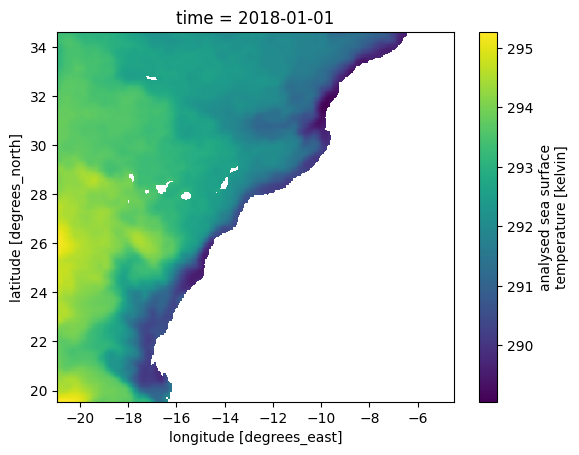

In [6]:
SST_SAT.isel(time=0)["analysed_sst"].plot()

In [7]:
# Load xarray dataset
REANALYS = copernicusmarine.open_dataset(dataset_id=reanalysis,
                                                     force_dataset_version="202311",
                                                     variables=["thetao"],
                                                     minimum_longitude=min_lon,
                                                     maximum_longitude=max_lon,
                                                     minimum_latitude=min_lat,
                                                     maximum_latitude=max_lat,
                                                     start_datetime=start_date,
                                                     end_datetime=end_date,
                                                     minimum_depth=0.49402499198913574,
                                                     maximum_depth=0.49402499198913574,
                                                     )


# Print loaded dataset information
REANALYS

WARNING - 2024-02-28T11:28:38Z - 'force_dataset_version' has been deprecated, use 'dataset_version' instead
INFO - 2024-02-28T11:28:39Z - You forced selection of dataset version "202311"
INFO - 2024-02-28T11:28:39Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-02-28T11:28:40Z - Service was not specified, the default one was selected: "arco-time-series"


<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 181, longitude: 198, time: 1096)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 19.58 19.67 19.75 19.83 ... 34.42 34.5 34.58
  * longitude  (longitude) float32 -20.92 -20.83 -20.75 ... -4.667 -4.583 -4.5
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-12-31
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-07-07 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

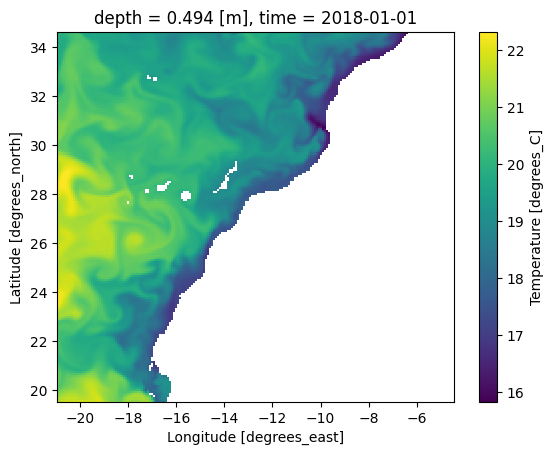

In [8]:
REANALYS.isel(time=0).isel(depth=0)["thetao"].plot()

## Resolution interpolation
---


In [9]:
SST_SAT_resized = interpolation.resize_lonxlat(SST_SAT, (198, 181))
SST_SAT_resized

<xarray.Dataset>
Dimensions:         (time: 1096, latitude: 181, longitude: 198)
Coordinates:
  * time            (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2020-12-31
  * longitude       (longitude) float64 -20.93 -20.84 -20.76 ... -4.608 -4.525
  * latitude        (latitude) float64 19.57 19.66 19.74 ... 34.41 34.49 34.58
Data variables:
    analysed_sst    (time, latitude, longitude) float64 295.3 295.3 ... nan nan
    analysis_error  (time, latitude, longitude) float64 0.15 0.15 ... nan nan
Attributes: (12/34)
    Conventions:                CF-1.4
    cdm_data_type:              grid
    cmems_product_id:           cmems_SST_ATL_SST_L4_REP_OBSERVATIONS_010_026
    contact:                    emmanuelle.autret@ifremer.fr,jean.francois.pi...
    date_created:               20201113T102920Z
    easternmost_longitude:      12.98
    ...                         ...
    stop_time:                  19820101T120000Z
    summary:                    Sea Surface Temperature Analysis from the Eur...
    temporal_resolution:        daily
    title:                      European North West Shelf/Iberia Biscay Irish...
    uuid:                       
    westernmost_longitude:      -20.98

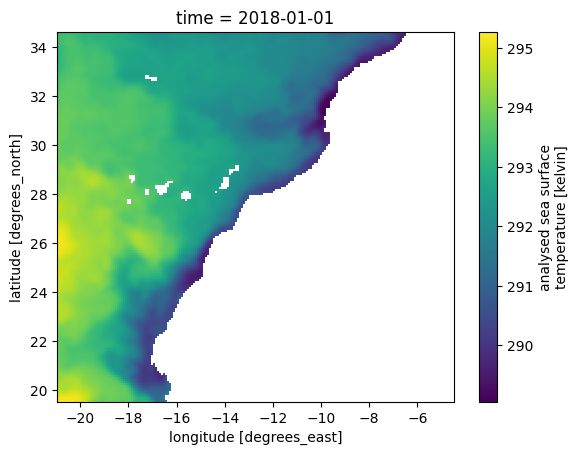

In [10]:
SST_SAT_resized["analysed_sst"].isel(time=0).plot()